In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib import rc

pd.options.mode.chained_assignment = None 

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (14,6)
plt.rcParams['axes.grid'] = True   

security_data = pd.read_excel("/Users/hyunwoo/Downloads/(한국투자증권)_샘플_및_명세.xlsx")
demand_data = pd.read_excel("/Users/hyunwoo/Downloads/(신한은행)_샘플_및_명세/(신한은행) MZ세대 트렌드 지표_샘플.xlsx")
    
def preprocessing(security_data,demand_data):
    security_columns = security_data.columns[5:]
    
    # 데이터 그룹화
    security_data["연령대"] = security_data['aha'].apply(lambda x : x.split(".")[1])
    security_data['기준년월'] = pd.to_datetime(security_data['기준년월'],format ="%Y%m")
    security_data['성별'] = security_data['성별'].apply(lambda x : 1 if (x == "남자") else 0)
    security_data['연령대'] = security_data['연령대'].str.replace("대","")
    security_data['연령대'] = security_data['연령대'].str.replace("이상","")
    
    local_encoder = LabelEncoder()
    
    demand_data['시군구'] = demand_data["주소"].apply(lambda x: x.split("_")[0])
    demand_data.fillna(0,inplace=True)
    
    age_grouping = {1:"20",2:"30",3:"40",4:"50",5:"60"}
    demand_data['나이대'] = demand_data['나이대'].apply(lambda x: age_grouping[x])
    demand_data
 #전체 데이터 주어질경우 공통되지 않은 "구" 데이터는 제거 할 필요가 있음 
#     demand_data['시군구코드'] = small_local_encoder.transform(demand_data['시군구'])
#     demand_data['그룹코드'] = demand_data['나이대'] + "_" + demand_data['그룹코드'].astype("str")


    local_encoder.fit(security_data['시군구'])
    security_data["시군구코드"] = local_encoder.transform(security_data['시군구'])
    security_data['그룹코드'] = security_data['연령대']+"_"+ security_data['시군구코드'].astype("str")
    
    security_data.drop(columns = {"aha","시도","시군구","시군구코드","연령대"},inplace = True)
    security_data = security_data[security_data.columns[-1:].to_list()+security_data.columns[:-1].to_list()]
    
    # 각각 상품 비율화
    security_only_data = security_data[security_data.columns[3:]]
    security_only_data['총합'] = security_only_data.sum(axis=1)
    security_data['총합'] = security_only_data['총합']
    
    for col in security_columns:
        security_data[col] = security_data[col]/security_data['총합']
        
    security_data.drop(columns = {"총합"},inplace = True)
    
    return security_data,demand_data,local_encoder.classes_

In [2]:
security,demand,grouping = preprocessing(security_data,demand_data)

In [3]:
grouping

array(['강릉시', '거제시', '광산구', '구로구', '서귀포시'], dtype=object)

In [4]:
# 직접 투자 vs 간접 투자
direct_investment = ["국내주식","해외주식","채권","장내파생상품",'단기금융상품']
indirect_investment = ['펀드','랩','신탁','연금',"파생결합증권"]

In [5]:
# 직접 투자 
security.groupby('그룹코드').mean()[direct_investment].sum(axis=1)

그룹코드
20_0    0.769091
20_4    0.880391
30_0    0.833616
30_1    0.954123
40_1    0.928831
40_2    0.789669
50_2    0.722740
50_3    0.744018
60_3    0.668566
60_4    0.682237
dtype: float64

In [6]:
# 간접 투자
security.groupby('그룹코드').mean()[indirect_investment].sum(axis=1)

그룹코드
20_0    0.120359
20_4    0.083652
30_0    0.084066
30_1    0.032020
40_1    0.049195
40_2    0.143205
50_2    0.222654
50_3    0.157551
60_3    0.159785
60_4    0.144192
dtype: float64

In [7]:
security.groupby('그룹코드').mean()["현물"]

그룹코드
20_0    0.000095
20_4    0.001111
30_0    0.000288
30_1    0.001262
40_1    0.001325
40_2    0.000505
50_2    0.000613
50_3    0.000715
60_3    0.001399
60_4    0.000168
Name: 현물, dtype: float64

In [8]:
demand

,기준년월,성별,나이대,신용카드보유유무,지출비율(50이상_50미만),주소,간편결제,구독서비스,통합적쇼핑플랫폼,택시,...,리셀플랫폼,슈퍼카/외제차,공과금,편의점,다이소,인앱결제,게임(PC방),비디오스트리밍,음악스트리밍,시군구
0,202104,1,20,0,0,강남구_도곡동,7.016,0.000,0.000,10.427,...,0.0,0.000,15.341,12.227,7.761,11.162,12.122,0.000,0.000,강남구
1,202104,1,20,0,0,금천구_독산동,5.725,0.000,0.000,0.000,...,0.0,0.000,0.000,12.840,4.752,8.585,12.028,0.000,0.000,금천구
2,202104,1,20,0,0,성동구_금호동1가,3.177,0.000,0.000,0.000,...,0.0,0.000,0.000,6.471,0.000,0.000,0.000,0.000,0.000,성동구
3,202104,1,20,0,0,영등포구_당산동4가,3.025,0.000,0.000,0.000,...,0.0,0.000,0.000,9.904,0.000,0.000,0.000,0.000,0.000,영등포구
4,202104,1,20,0,1,강동구_고덕동,13.102,11.402,14.002,12.912,...,0.0,0.000,0.000,18.071,7.288,12.167,18.517,0.000,12.157,강동구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,202104,1,50,0,1,영등포구_양평동5가,20.386,0.000,0.000,0.000,...,0.0,0.000,0.000,30.608,0.000,0.000,0.000,0.000,0.000,영등포구
96,202104,1,50,0,1,용산구_원효로4가,13.601,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,용산구
97,202104,1,50,1,0,강남구_일원동,13.003,31.608,0.000,13.452,...,0.0,63.401,17.504,18.641,14.744,10.128,5.996,40.161,0.000,강남구
98,202104,1,50,1,0,강서구_등촌동,13.342,27.291,16.458,13.459,...,0.0,52.065,19.642,21.855,14.921,16.307,12.054,39.690,39.010,강서구


In [9]:
security

,그룹코드,성별,기준년월,국내주식,해외주식,채권,파생결합증권,장내파생상품,단기금융상품,펀드,랩,신탁,연금,현금성자산,현물,기타
0,20_0,1,2021-02-01,0.530770,0.221362,0.010658,0.010309,0.0,0.000000,0.068838,0.017821,0.0,0.020627,0.119518,0.000096,0.0
1,20_0,1,2021-03-01,0.552040,0.222956,0.004375,0.010004,0.0,0.000000,0.081246,0.014713,0.0,0.012161,0.102342,0.000163,0.0
2,20_0,1,2021-11-01,0.563691,0.204540,0.026413,0.000000,0.0,0.035947,0.053261,0.022535,0.0,0.027940,0.065523,0.000149,0.0
3,20_0,1,2021-04-01,0.556756,0.221371,0.004768,0.006890,0.0,0.013992,0.081372,0.014182,0.0,0.013699,0.086745,0.000225,0.0
4,20_0,1,2021-06-01,0.557486,0.201864,0.019791,0.000000,0.0,0.000000,0.078618,0.012741,0.0,0.033593,0.095595,0.000312,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,60_4,0,2021-12-01,0.512536,0.050519,0.108692,0.009360,0.0,0.035225,0.058672,0.014586,0.0,0.025683,0.184187,0.000541,0.0
96,60_4,0,2021-11-01,0.546219,0.048154,0.134439,0.005140,0.0,0.037385,0.069859,0.012031,0.0,0.029107,0.117072,0.000594,0.0
97,60_4,0,2021-10-01,0.538259,0.043407,0.147534,0.004419,0.0,0.036141,0.073288,0.009906,0.0,0.027022,0.119475,0.000549,0.0
98,60_4,0,2021-02-01,0.416700,0.029629,0.119386,0.014989,0.0,0.036205,0.076404,0.016389,0.0,0.023516,0.266783,0.000000,0.0


In [10]:
## 직접투자 vs 간접투자
cash = ["현금성자산","현물"]

security["직접투자"] = 0
security['간접투자'] = 0
security['현물보유'] = 0

for i in direct_investment:
    security['직접투자'] += security[i]
    
for i in indirect_investment:
    security['간접투자'] += security[i]  
    
for i in cash:
    security['현물보유'] += security[i]


<AxesSubplot:>

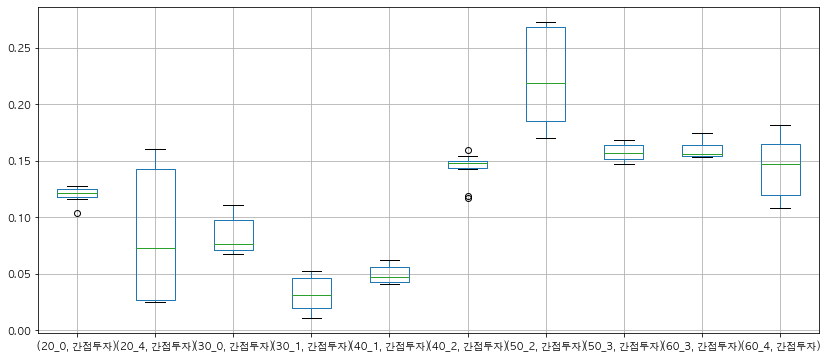

In [11]:
# 간접투자 특징 집단별 
group_data = security.groupby("그룹코드")
group_data.boxplot("그룹코드","간접투자")


<AxesSubplot:>

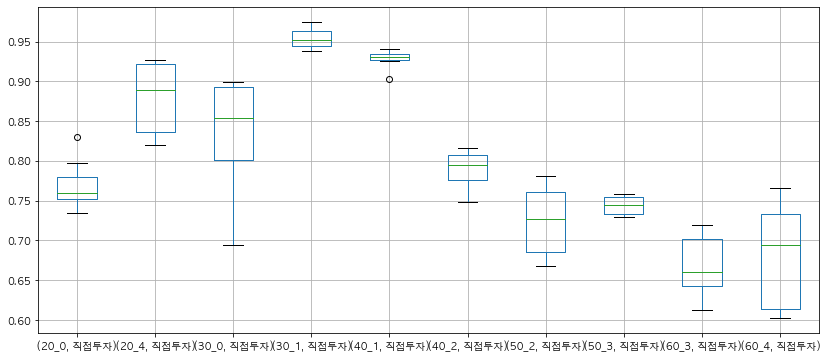

In [12]:
# 직접투자 특징 집단별
security.groupby("그룹코드").boxplot("그룹코드","직접투자")

In [13]:
security

,그룹코드,성별,기준년월,국내주식,해외주식,채권,파생결합증권,장내파생상품,단기금융상품,펀드,랩,신탁,연금,현금성자산,현물,기타,직접투자,간접투자,현물보유
0,20_0,1,2021-02-01,0.530770,0.221362,0.010658,0.010309,0.0,0.000000,0.068838,0.017821,0.0,0.020627,0.119518,0.000096,0.0,0.762791,0.117595,0.119615
1,20_0,1,2021-03-01,0.552040,0.222956,0.004375,0.010004,0.0,0.000000,0.081246,0.014713,0.0,0.012161,0.102342,0.000163,0.0,0.779371,0.118124,0.102505
2,20_0,1,2021-11-01,0.563691,0.204540,0.026413,0.000000,0.0,0.035947,0.053261,0.022535,0.0,0.027940,0.065523,0.000149,0.0,0.830591,0.103736,0.065672
3,20_0,1,2021-04-01,0.556756,0.221371,0.004768,0.006890,0.0,0.013992,0.081372,0.014182,0.0,0.013699,0.086745,0.000225,0.0,0.796887,0.116142,0.086970
4,20_0,1,2021-06-01,0.557486,0.201864,0.019791,0.000000,0.0,0.000000,0.078618,0.012741,0.0,0.033593,0.095595,0.000312,0.0,0.779140,0.124952,0.095908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,60_4,0,2021-12-01,0.512536,0.050519,0.108692,0.009360,0.0,0.035225,0.058672,0.014586,0.0,0.025683,0.184187,0.000541,0.0,0.706972,0.108300,0.184728
96,60_4,0,2021-11-01,0.546219,0.048154,0.134439,0.005140,0.0,0.037385,0.069859,0.012031,0.0,0.029107,0.117072,0.000594,0.0,0.766197,0.116137,0.117666
97,60_4,0,2021-10-01,0.538259,0.043407,0.147534,0.004419,0.0,0.036141,0.073288,0.009906,0.0,0.027022,0.119475,0.000549,0.0,0.765341,0.114635,0.120024
98,60_4,0,2021-02-01,0.416700,0.029629,0.119386,0.014989,0.0,0.036205,0.076404,0.016389,0.0,0.023516,0.266783,0.000000,0.0,0.601920,0.131297,0.266783


In [14]:
order_by = security.sort_values(["그룹코드",'기준년월'],ascending = True)
order_by = order_by[['그룹코드','기준년월','직접투자','간접투자','현금성자산','현물']]

indirect_pct_change = pd.Series()
direct_pct_change = pd.Series()
indirect_list = []
direct_list = []

for group_code in order_by['그룹코드'].unique():
    A = order_by[order_by['그룹코드']==group_code]
    A['간접투자변화율'] = A['간접투자'].pct_change()
    A['직접투자변화율'] = A['직접투자'].pct_change()
    
    indirect_list += list(A['간접투자변화율'].values)
    direct_list += list(A['직접투자변화율'].values)


indirect_pct_change = pd.Series(indirect_list)    
direct_pct_change = pd.Series(direct_list)    

order_by['직접투자변화율'] = direct_pct_change
order_by['간접투자변화율'] = indirect_pct_change

order_by

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


,그룹코드,기준년월,직접투자,간접투자,현금성자산,현물,직접투자변화율,간접투자변화율
0,20_0,2021-02-01,0.762791,0.117595,0.119518,0.000096,NaN,NaN
1,20_0,2021-03-01,0.779371,0.118124,0.102342,0.000163,0.021737,0.004500
3,20_0,2021-04-01,0.796887,0.116142,0.086745,0.000225,-0.022271,0.075852
4,20_0,2021-06-01,0.779140,0.124952,0.095595,0.000312,-0.029448,0.002929
9,20_0,2021-08-01,0.756196,0.125318,0.118486,0.000000,-0.014912,-0.003262
...,...,...,...,...,...,...,...,...
97,60_4,2021-10-01,0.765341,0.114635,0.119475,0.000549,0.044255,-0.325630
90,60_4,2021-11-01,0.733726,0.172216,0.094058,0.000000,NaN,NaN
96,60_4,2021-11-01,0.766197,0.116137,0.117072,0.000594,-0.041308,0.502297
92,60_4,2021-12-01,0.729700,0.167396,0.102904,0.000000,-0.023064,-0.278357


In [15]:
order_by

,그룹코드,기준년월,직접투자,간접투자,현금성자산,현물,직접투자변화율,간접투자변화율
0,20_0,2021-02-01,0.762791,0.117595,0.119518,0.000096,NaN,NaN
1,20_0,2021-03-01,0.779371,0.118124,0.102342,0.000163,0.021737,0.004500
3,20_0,2021-04-01,0.796887,0.116142,0.086745,0.000225,-0.022271,0.075852
4,20_0,2021-06-01,0.779140,0.124952,0.095595,0.000312,-0.029448,0.002929
9,20_0,2021-08-01,0.756196,0.125318,0.118486,0.000000,-0.014912,-0.003262
...,...,...,...,...,...,...,...,...
97,60_4,2021-10-01,0.765341,0.114635,0.119475,0.000549,0.044255,-0.325630
90,60_4,2021-11-01,0.733726,0.172216,0.094058,0.000000,NaN,NaN
96,60_4,2021-11-01,0.766197,0.116137,0.117072,0.000594,-0.041308,0.502297
92,60_4,2021-12-01,0.729700,0.167396,0.102904,0.000000,-0.023064,-0.278357


In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

order_by.dropna(inplace= True)
target_data = order_by[['직접투자','간접투자','직접투자변화율','간접투자변화율']]
# sc = StandardScaler()
# cc_scaled = sc.fit_transform(target_data)
# target_data = pd.DataFrame(cc_scaled,columns = ["직접투자","간접투자"])

# target_data

In [17]:
kmeans = KMeans(n_clusters = 2)
clusters = kmeans.fit(target_data)
target_data['클러스터'] = clusters.labels_
target_data

,직접투자,간접투자,직접투자변화율,간접투자변화율,클러스터
1,0.779371,0.118124,0.021737,0.004500,1
3,0.796887,0.116142,-0.022271,0.075852,1
4,0.779140,0.124952,-0.029448,0.002929,1
9,0.756196,0.125318,-0.014912,-0.003262,1
8,0.755640,0.124337,-0.102591,0.228982,1
...,...,...,...,...,...
91,0.682247,0.155182,0.004243,0.280763,1
97,0.765341,0.114635,0.044255,-0.325630,1
96,0.766197,0.116137,-0.041308,0.502297,1
92,0.729700,0.167396,-0.023064,-0.278357,1


/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='간접투자', ylabel='직접투자'>

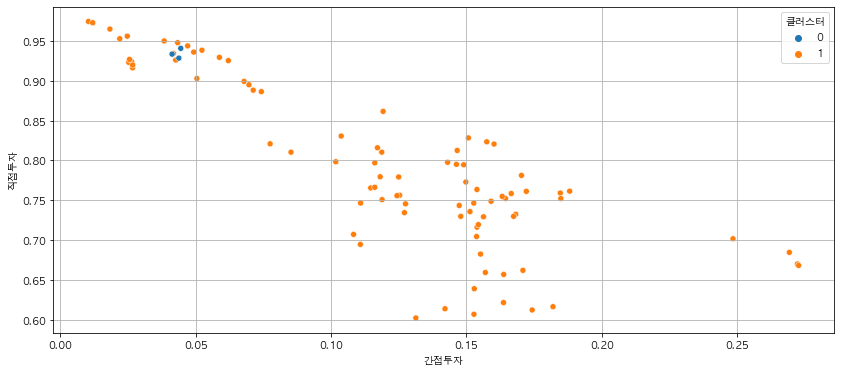

In [18]:
import seaborn as sns
sns.scatterplot("간접투자","직접투자",hue = "클러스터", data= target_data)

In [19]:
target_data.groupby(["그룹코드","클러스터"])['클러스터'].count()

KeyError: '그룹코드'

In [ ]:
clusters.inertia_

In [ ]:
from somlearn import SOM

In [20]:
order_by = security.sort_values(["그룹코드",'기준년월'],ascending = True)
order_by = order_by[['그룹코드','기준년월','직접투자','간접투자','현물보유']]

indirect_pct_change = []
direct_pct_change = []
cash_pct_change = []

indirect_list = []
direct_list = []
cash_list = []

for group_code in order_by['그룹코드'].unique():
    A = order_by[order_by['그룹코드']==group_code]
    A['직접투자3개월가중평균'] = A['직접투자'].ewm(span=3).mean()
    A['간접투자3개월가중평균'] = A['간접투자'].ewm(span=3).mean()
    A['현물보유3개월가중평균'] = A['현물보유'].ewm(span=3).mean()
    
    A['직접투자비율변화'] = A['직접투자'].pct_change()
    A['간접투자비율변화'] = A['간접투자'].pct_change()
    A['현물비율변화'] = A['현물보유'].pct_change()
    
    indirect_list += list(A['간접투자3개월가중평균'].values)
    direct_list += list(A['직접투자3개월가중평균'].values)
    cash_list += list(A['현물보유3개월가중평균'].values)
    
    indirect_pct_change += list(A['간접투자비율변화'].values)
    direct_pct_change += list(A['직접투자비율변화'].values)
    cash_pct_change += list(A['현물비율변화'].values)
    
indirect_evm = pd.Series(indirect_list)    
direct_evm = pd.Series(direct_list)    
cash_evm = pd.Series(cash_list)

indirect_pct = pd.Series(indirect_pct_change)
direct_pct = pd.Series(direct_pct_change)
cash_pct = pd.Series(cash_pct_change)

order_by['직접투자3개월가중평균'] = direct_evm
order_by['간접투자3개월가중평균'] = indirect_evm
order_by['현물보유3개월가중평균'] = cash_evm
order_by['직접투자변화율'] = direct_pct
order_by['간접투자변화율'] = indirect_pct
order_by['현물변화율'] = cash_pct


In [21]:
order_by.dropna(inplace=True)
training_set = order_by[order_by.columns[2:]]

In [ ]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters = 3)
clusters = kmeans.fit(training_set)
order_by['클러스터'] = clusters.labels_
order_by

In [ ]:
order_by.groupby("클러스터").size()

In [ ]:
order_by.groupby(['그룹코드',"클러스터"]).size()

In [ ]:
order_by.groupby(["그룹코드","클러스터"]).mean()[["직접투자","간접투자","현물보유"]]

In [ ]:
order_by.groupby("클러스터").mean()[["직접투자","간접투자","현물보유"]]

In [ ]:
order_by.groupby("클러스터").size()

In [ ]:
kmeans.cluster_centers_

In [ ]:
kmeans.feature_names_in_

In [22]:
# GMM 적용
from sklearn.mixture import GaussianMixture
# n_components로 미리 군집 개수 설정
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(iris.data)

# GMM 후 클러스터링 레이블을 따로 설정
irisDF['gmm_cluster'] = gmm_labels

# 실제 레이블과 GMM 클러스터링 후 레이블과 비교해보기(두 레이블 수치가 동일해야 똑같은 레이블 의미 아님!)
print(irisDF.groupby('target')['gmm_cluster'].value_counts())

NameError: name 'iris' is not defined

In [28]:
order_by

,그룹코드,기준년월,직접투자,간접투자,현물보유,직접투자3개월가중평균,간접투자3개월가중평균,현물보유3개월가중평균,직접투자변화율,간접투자변화율,현물변화율,gmm_cluster
1,20_0,2021-03-01,0.779371,0.118124,0.102505,0.773844,0.117948,0.108208,0.021737,0.004500,-0.143042,2
3,20_0,2021-04-01,0.796887,0.116142,0.086970,0.782814,0.121202,0.095984,-0.022271,0.075852,0.102766,2
4,20_0,2021-06-01,0.779140,0.124952,0.095908,0.769075,0.123326,0.107598,-0.029448,0.002929,0.235416,2
9,20_0,2021-08-01,0.756196,0.125318,0.118486,0.751847,0.123543,0.124610,-0.014912,-0.003262,0.090700,2
8,20_0,2021-09-01,0.755640,0.124337,0.120023,0.769464,0.120004,0.110532,-0.102591,0.228982,0.935825,2
...,...,...,...,...,...,...,...,...,...,...,...,...
91,60_4,2021-10-01,0.682247,0.155182,0.162571,0.615263,0.168647,0.216090,0.004243,0.280763,-0.173834,1
97,60_4,2021-10-01,0.765341,0.114635,0.120024,0.743313,0.134477,0.122209,0.044255,-0.325630,0.250990,2
96,60_4,2021-11-01,0.766197,0.116137,0.117666,0.720249,0.152962,0.126788,-0.041308,0.502297,-0.216340,1
92,60_4,2021-12-01,0.729700,0.167396,0.102904,0.607638,0.147304,0.245058,-0.023064,-0.278357,0.321182,2


In [41]:
target = order_by[order_by.columns[2:5]]
#target.drop(columns={"gmm_cluster"},inplace=True)

KeyError: "['gmm_cluster'] not found in axis"

In [42]:
target

,직접투자,간접투자,현물보유
1,0.779371,0.118124,0.102505
3,0.796887,0.116142,0.086970
4,0.779140,0.124952,0.095908
9,0.756196,0.125318,0.118486
8,0.755640,0.124337,0.120023
...,...,...,...
91,0.682247,0.155182,0.162571
97,0.765341,0.114635,0.120024
96,0.766197,0.116137,0.117666
92,0.729700,0.167396,0.102904


In [47]:
proba_df = pd.DataFrame()
proba_df["Cluster0"] = gmm.predict_proba(target)[:,0]
proba_df["Cluster1"] = gmm.predict_proba(target)[:,1]
proba_df["Cluster2"] = gmm.predict_proba(target)[:,2]
proba_df

,Cluster0,Cluster1,Cluster2
0,0.995085,0.004915,8.545676e-10
1,0.998721,0.001279,1.533231e-07
2,0.995445,0.004555,1.004259e-09
3,0.970862,0.029138,4.174688e-13
4,0.968884,0.031116,3.080583e-13
...,...,...,...
85,0.131816,0.868184,1.166736e-26
86,0.984519,0.015481,4.371851e-12
87,0.985624,0.014376,7.203704e-12
88,0.977665,0.022335,6.081978e-17


In [48]:
# GMM 적용
from sklearn.mixture import GaussianMixture
# n_components로 미리 군집 개수 설정
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(target)
gmm_proba = gmm.predict_proba(target)
# GMM 후 클러스터링 레이블을 따로 설정
target['gmm_cluster'] = gmm_labels

In [53]:
target.reset_index(inplace=True,drop=True)
target.drop(columns={"index"},inplace=True)
target

,직접투자,간접투자,현물보유,gmm_cluster
0,0.779371,0.118124,0.102505,0
1,0.796887,0.116142,0.086970,0
2,0.779140,0.124952,0.095908,0
3,0.756196,0.125318,0.118486,0
4,0.755640,0.124337,0.120023,0
...,...,...,...,...
85,0.682247,0.155182,0.162571,1
86,0.765341,0.114635,0.120024,0
87,0.766197,0.116137,0.117666,0
88,0.729700,0.167396,0.102904,0


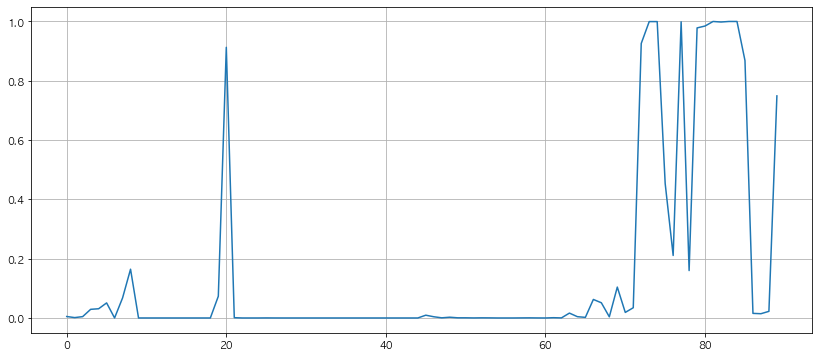

In [80]:
plt.plot(proba_df['현물보유선호'])

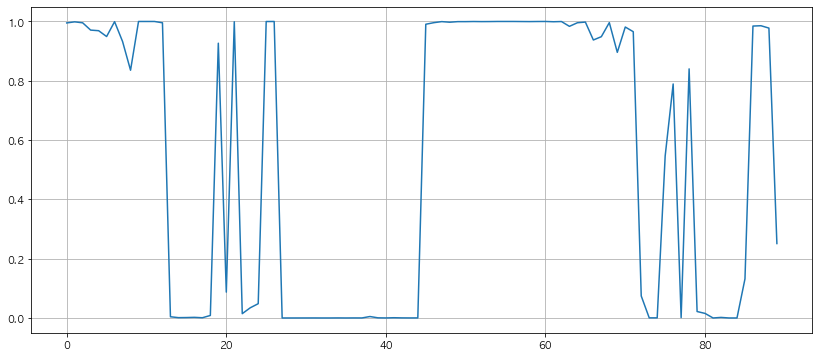

In [76]:
plt.plot(proba_df['간접투자선호'])

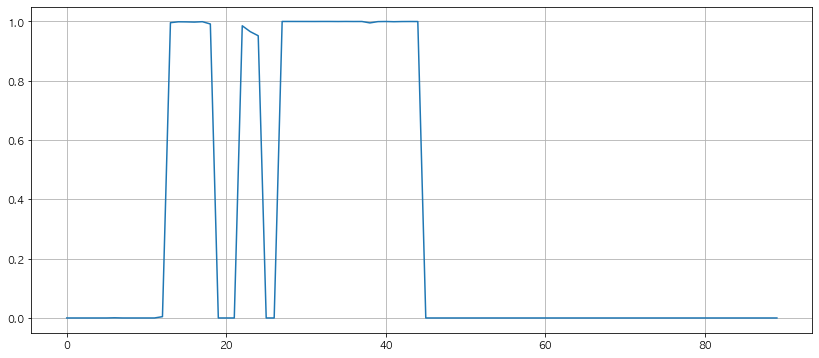

In [77]:
plt.plot(proba_df['직접투자선호'])

In [79]:
proba_df

,간접투자선호,현물보유선호,직접투자선호
0,0.995085,0.004915,8.545676e-10
1,0.998721,0.001279,1.533231e-07
2,0.995445,0.004555,1.004259e-09
3,0.970862,0.029138,4.174688e-13
4,0.968884,0.031116,3.080583e-13
...,...,...,...
85,0.131816,0.868184,1.166736e-26
86,0.984519,0.015481,4.371851e-12
87,0.985624,0.014376,7.203704e-12
88,0.977665,0.022335,6.081978e-17


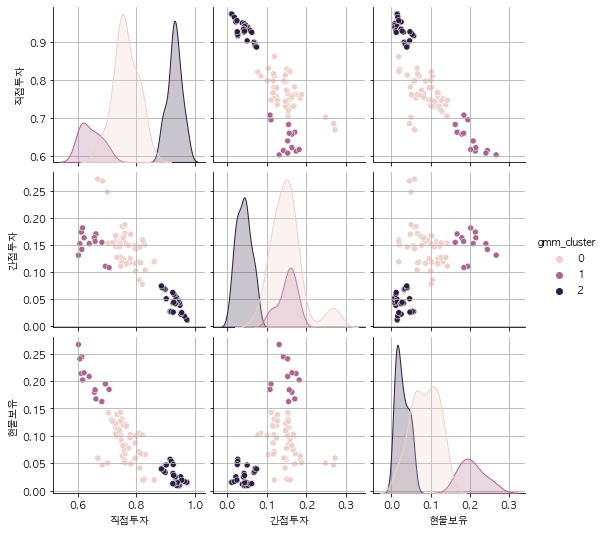

In [56]:
import seaborn as sns
sns.pairplot(target[target.columns[0:4]],hue = "gmm_cluster")

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

<AxesSubplot:xlabel='직접투자선호', ylabel='Density'>

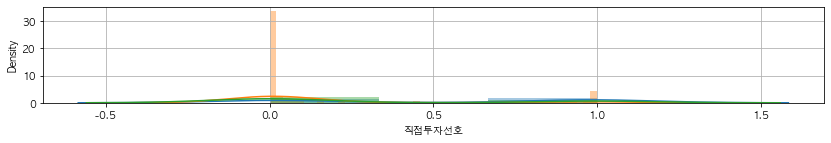

In [72]:
#proba_df.rename(columns = {"Cluster0" : "간접투자선호","Cluster1":"현물보유선호","Cluster2":"직접투자선호"},inplace= True)

plt.subplot(312)
sns.distplot(proba_df[proba_df.columns[0]])
sns.distplot(proba_df[proba_df.columns[1]])
sns.distplot(proba_df[proba_df.columns[2]])
#클러스터 2 : 직접투자 선호 , 클러스터 1 : 현물보유 선호 , 클러스터 0 : 간접투자 선호

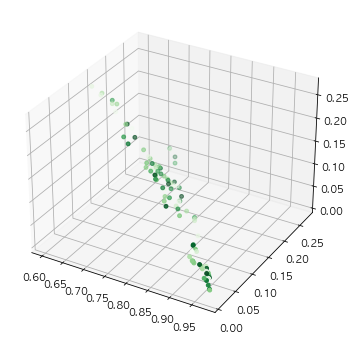

In [73]:
cmin, cmax = 0, 2

color = np.array([(cmax - cmin) * np.random.random_sample() + cmin for i in range(len(order_by))])


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(order_by['직접투자'],order_by['간접투자'],order_by['현물보유'], c = color,marker='o', s=15, cmap='Greens')

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(order_by['직접투자'],order_by['간접투자'])

In [ ]:
plt.scatter(order_by['직접투자'],order_by['현물보유'])

In [ ]:

plt.scatter(order_by['간접투자'],order_by['현물보유'])